In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse, io 
import numpy as np
import rpy2.robjects as robjects
import magic
import scprep
from sklearn.decomposition import NMF, non_negative_factorization, PCA
from sklearn.decomposition._nmf import _beta_divergence
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix 


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *
from findK_correction_jk import *

import pdb

np.random.seed(123)

In [2]:
Yfile = "../../ebpmf_data_analysis/output/fastTopics_fit/sla_small.txt"
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_fitted.Rds"
vocabfile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_vocab.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"

## load data and fitted L, F, s
Y = io.mmread(Yfile)
Y = Y.toarray()
vocab = np.loadtxt(vocabfile, dtype = str)
readRDS = robjects.r['readRDS']
data = readRDS(datafile)
w_idx = np.asarray(data.rx2('word_idx')).astype(int)
fitted = data.rx2('fit_sub')
F = np.asarray(fitted.rx2('F'))
L = np.asarray(fitted.rx2('L'))
s = np.asarray(fitted.rx2('s'))
p, k = F.shape
n = L.shape[0]

C = L @ F.T
C = C.T @ C / n
Cbar = C / C.sum(axis = 1)[:, None]
w_true = C.sum(axis = 1)

C_ = compute_C_unbiased(Y)
Cbar_ = C_ / C_.sum(axis = 1)[:, None]


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0832 seconds

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0720 seconds

(array([1669, 1888,  178, 1666,  490, 1933]), array([413, 904, 649, 733, 471, 443]))
(array([ 452, 1056,  812, 1440,  463, 1039]), array([21, 40, 46, 20, 20, 21]))
(array([1147., 1888., 1175.,  178., 1681.,  632.]), array([509, 904, 152, 649, 423, 196]))


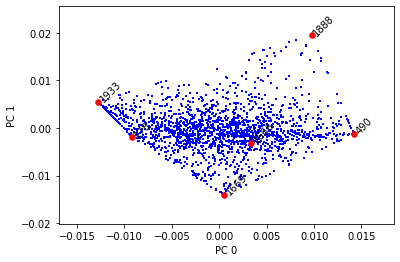

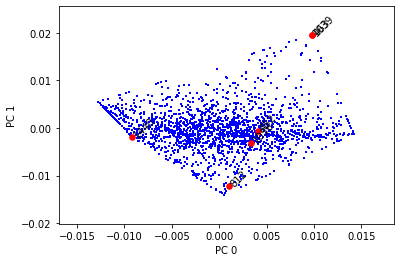

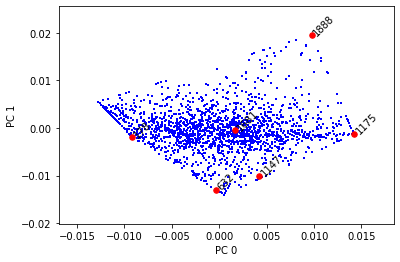

In [3]:
#%%capture
S0, diagR0, _ = findS(Cbar, k)
S1, diagR1, _ = findS(Cbar_, k)
S2, diagR2 = findS_correction_jk(Y.astype(float), Cbar_, C_, k, prior_family = "point_normal")

print((S0, Y.sum(axis = 0)[S0.astype(int)]))
print((S1, Y.sum(axis = 0)[S1.astype(int)]))
print((S2, Y.sum(axis = 0)[S2.astype(int)]))

Cbar_pj = pca_proj(Cbar)
vis_extremal_pca(Cbar_pj, S0.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S1.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S2.astype(int), [0, 1], annotate=True, fontsize=10)

In [4]:
def get_truth(Cbar0, X, Cbar, C, K, prior_family = "point_normal"):
    n, p = X.shape
    d = X.sum(axis = 1)
    D = d * (d - 1)
    w = X.sum(axis = 0)
    w /= w.sum()
    W = compute_W(X, w, d)
    
    U = np.zeros((p, K))
    S = np.zeros(K)
    gs0 = np.zeros((p, K)) ## truth
    gs1 = np.zeros((p, K)) ## naive
    gs2 = np.zeros((p, K)) ## de-biased
    gs3 = np.zeros((p, K)) ## shrunk
    vs = np.zeros((p, K))
    
    R = Cbar0.T
    g = (R**2).sum(axis = 0) 
    theta, Theta = JK_step1(X, W, w, C, Cbar, D)
    g1 = (Cbar**2).sum(axis = 1)
    g2 = theta
    G = Theta
    v = v_jk(G)
    g3 = shrink(g2 , v, prior_family)
    
    
    for k in range(K):
        gs0[:, k] = g
        gs1[:, k] = g1
        gs2[:, k] = g2
        gs3[:, k] = g3
        vs[:, k] = v
        
        maxSquaredSum = np.max(g)
        maxCol = np.argmax(g)
        S[k] = maxCol
        u = R[:, maxCol].copy()
        u = u / np.sqrt(maxSquaredSum)
        U[:, k] = u
        R = R -  u[:, None] @ (u[:,None].T @ R)
        dg = (Cbar0 @ u)**2
        g -= dg        
        
        g1 -= (Cbar @ u)**2
        theta, Theta = JK_stepk(X, W, w, u, C, Cbar, D)
        g2 -= theta
        G -= Theta
        v = v_jk(G)
        g3 = shrink(g2 , v, prior_family)

    return S, U, gs0, gs1, gs2, gs3, vs

import matplotlib.colors as mcolors

def visualize_shrinkage(k_, gs0, gs1, gs2, gs3, vs, a_words, a_words_all, Cbar_pj, colors):
    p, k = gs0.shape
    top_words_print = 5
    
    ind = np.zeros(p, dtype=bool)
    ind[a_words_all] = True
    
    
    ## test
    x = gs0[:, k_]
    y = np.sqrt(vs[:, k_])
    plt.scatter(x[~ind], y[~ind], c = "black", alpha = 0.1)
    for i in range(k):
        ind1 = np.zeros(p, dtype=bool)
        ind1[a_words[i]] = True 
        plt.scatter(x[ind1], y[ind1], c = colors[i], alpha = 0.5)
    plt.xlim((0.9 * x.min(), 1.1 * x.max()))
    plt.ylim((0.9 * y.min(), 1.1 * y.max()))
    plt.xlabel("'true' g")
    plt.ylabel("SE(ghat) estimated")
    plt.show()
    
    
    x = gs2[:, k_]
    y = np.sqrt(vs[:, k_])
    plt.scatter(x[~ind], y[~ind], c = "black", alpha = 0.1)
    for i in range(k):
        ind1 = np.zeros(p, dtype=bool)
        ind1[a_words[i]] = True 
        plt.scatter(x[ind1], y[ind1], c = colors[i], alpha = 0.5)
    plt.xlim((0.9 * x.min(), 1.1 * x.max()))
    plt.ylim((0.9 * y.min(), 1.1 * y.max()))
    plt.xlabel("ghat (debiased)")
    plt.ylabel("SE(ghat) estimated")
    plt.show()
    
    x = gs0[:, k_]
    y = gs1[:, k_]
    plt.scatter(x[~ind], y[~ind], c = "black", alpha = 0.1)
    for i in range(k):
        ind1 = np.zeros(p, dtype=bool)
        ind1[a_words[i]] = True 
        plt.scatter(x[ind1], y[ind1], c = colors[i], alpha = 0.5)
    plt.xlim((0.9 * x.min(), 1.1 * x.max()))
    plt.ylim((0.9 * y.min(), 1.1 * y.max()))
    plt.xlabel(" 'true' g")
    plt.ylabel("ghat (naive)")
    plt.show()
    
    ix = (-y).argsort()[:top_words_print]
    print(f'max words {vocab[ix]}')
    print(f'max words {ix}')
    vis_extremal_pca(Cbar_pj, ix, 
                     [0, 1], annotate=True, fontsize=10)
    
    x = gs0[:, k_]
    y = gs2[:, k_]
    plt.scatter(x[~ind], y[~ind], c = "black", alpha = 0.1)
    for i in range(k):
        ind1 = np.zeros(p, dtype=bool)
        ind1[a_words[i]] = True 
        plt.scatter(x[ind1], y[ind1], c = colors[i], alpha = 0.5)
    plt.xlim((0.9 * x.min(), 1.1 * x.max()))
    plt.ylim((0.9 * y.min(), 1.1 * y.max()))
    plt.xlabel(" 'true' g")
    plt.ylabel("ghat (de-biased)")
    plt.show()
    
    ix = (-y).argsort()[:top_words_print]
    print(f'max words {vocab[ix]}')
    print(f'max words {ix}')
    vis_extremal_pca(Cbar_pj, ix, 
                     [0, 1], annotate=True, fontsize=10)
    
    x = gs0[:, k_]
    y = gs3[:, k_]
    plt.scatter(x[~ind], y[~ind], c = "black", alpha = 0.1)
    for i in range(k):
        ind1 = np.zeros(p, dtype=bool)
        ind1[a_words[i]] = True 
        plt.scatter(x[ind1], y[ind1], c = colors[i], alpha = 0.5)
    plt.xlim((0.9 * x.min(), 1.1 * x.max()))
    plt.ylim((0.9 * y.min(), 1.1 * y.max()))
    plt.xlabel(" 'true' g")
    plt.ylabel("ghat (shrunk)")
    plt.show()
    
    ix = (-y).argsort()[:top_words_print]
    print(f'max words {vocab[ix]}')
    print(f'max words {ix}')
    vis_extremal_pca(Cbar_pj, ix, 
                     [0, 1], annotate=True, fontsize=10)


In [5]:
S, U, gs0, gs1, gs2, gs3, vs = get_truth(Cbar, Y.astype(float), Cbar_, C_, k, prior_family = "point_normal")
## get all true anchor words
a_words = {}
a_words_all = []
for i in range(k):
    s = S[i].astype(int)
    k_ = np.argmax(F[s, :])
    a_words[i] = np.where(find_anchor_word_k2(F, k_, 10) == True)[0]
    a_words_all += a_words[i].tolist()
a_words_all = np.array(a_words_all)

['k=0 red', 'k=1 blue', 'k=2 green', 'k=3 orange', 'k=4 brown', 'k=5 purple']
step 1


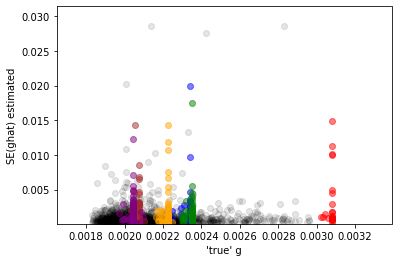

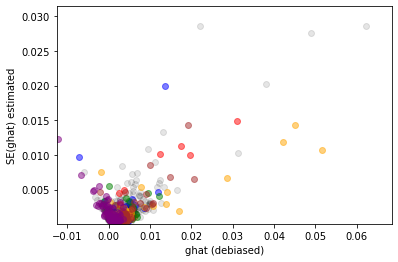

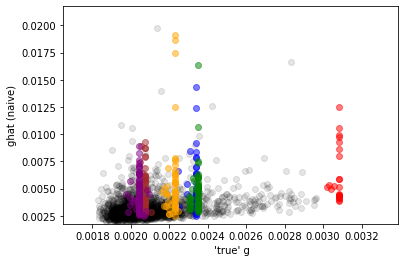

max words ['"critical"' '"x"' '"latent"' '"hybrid"' '"general"']
max words [ 452    0 1056  885  812]


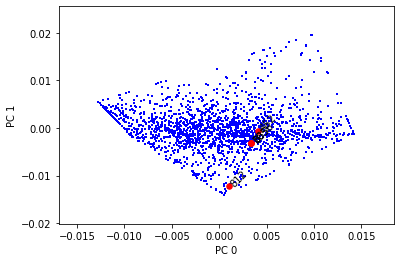

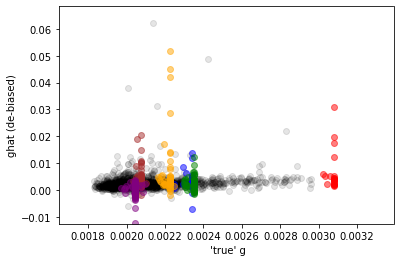

max words ['"critical"' '"x"' '"normally"' '"latent"' '"hybrid"']
max words [ 452    0 1268 1056  885]


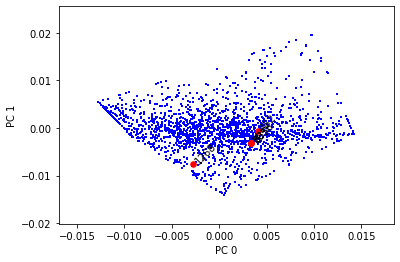

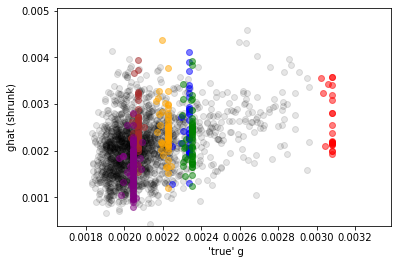

max words ['"maximizing"' '"designed"' '"estimation"' '"estimator"' '"suffer"']
max words [1147  508  649  650 1839]


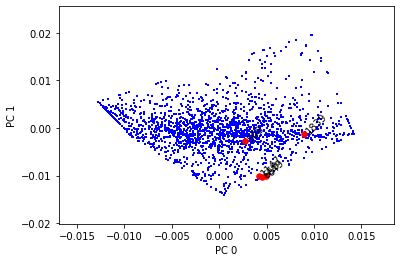

step 2


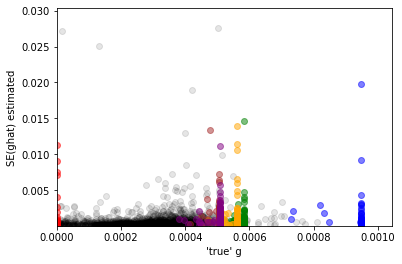

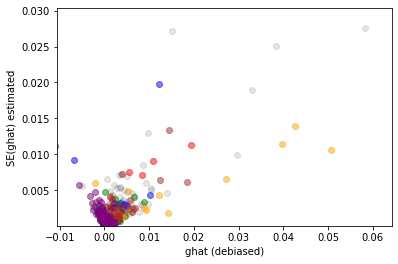

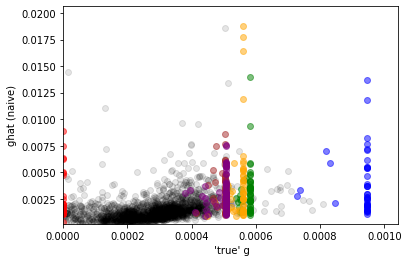

max words ['"x"' '"critical"' '"latent"' '"hybrid"' '"general"']
max words [   0  452 1056  885  812]


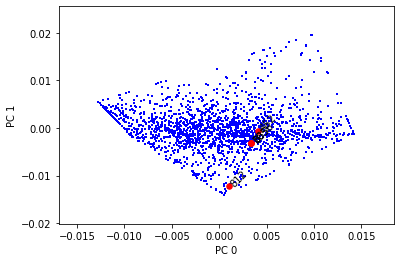

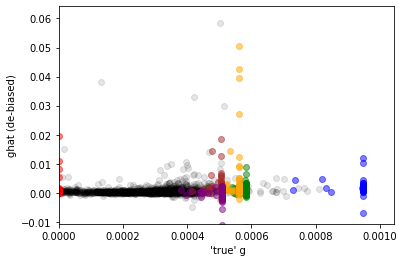

max words ['"critical"' '"x"' '"latent"' '"hybrid"' '"normally"']
max words [ 452    0 1056  885 1268]


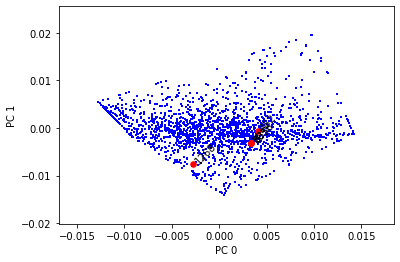

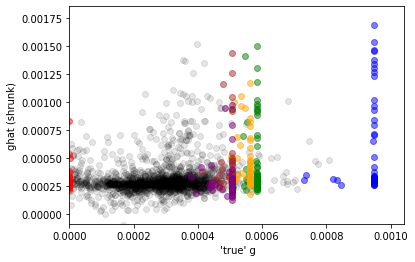

max words ['"statist"' '"terms"' '"describes"' '"priori"' '"nuisance"']
max words [1793 1888  506 1446 1273]


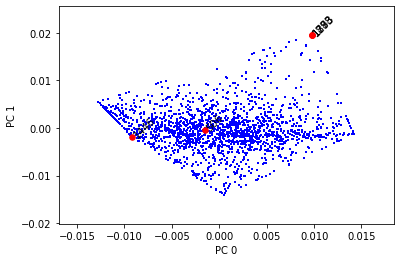

step 3


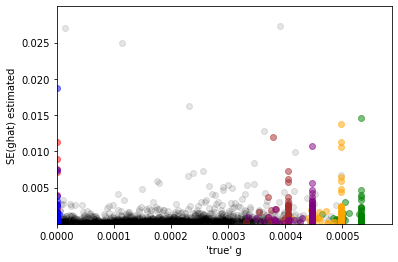

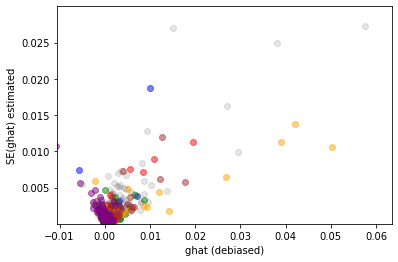

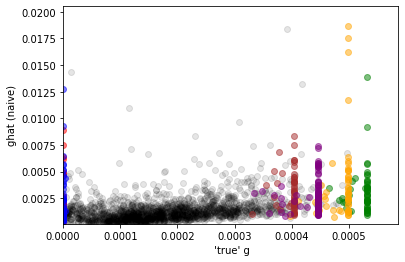

max words ['"x"' '"critical"' '"latent"' '"hybrid"' '"general"']
max words [   0  452 1056  885  812]


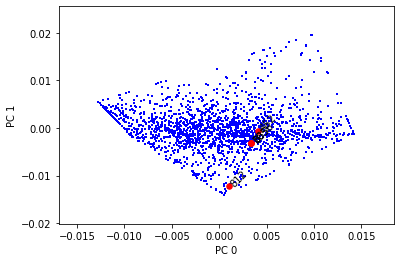

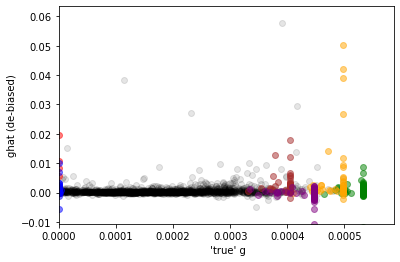

max words ['"critical"' '"x"' '"latent"' '"hybrid"' '"normally"']
max words [ 452    0 1056  885 1268]


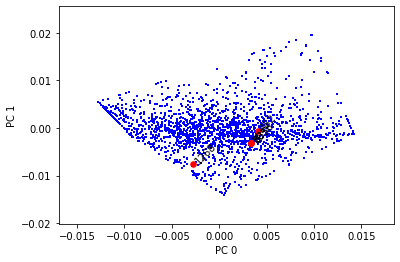

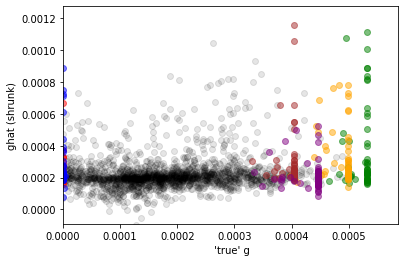

max words ['"minimal"' '"possibly"' '"principle"' '"densities"' '"serial"']
max words [1175 1411 1444  490 1681]


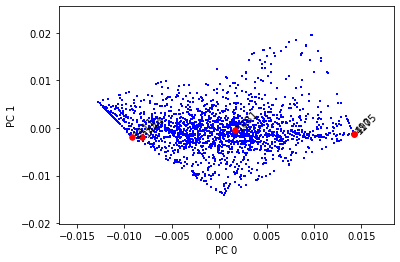

step 4


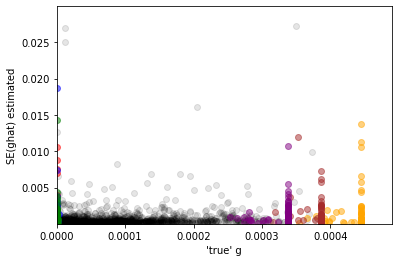

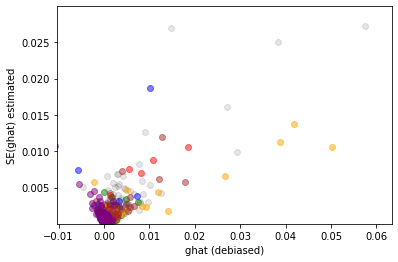

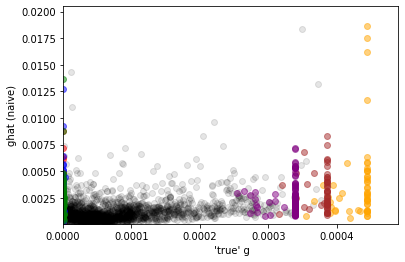

max words ['"x"' '"critical"' '"latent"' '"hybrid"' '"general"']
max words [   0  452 1056  885  812]


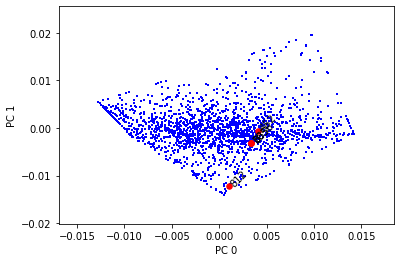

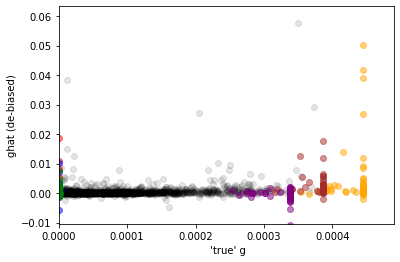

max words ['"critical"' '"x"' '"latent"' '"hybrid"' '"normally"']
max words [ 452    0 1056  885 1268]


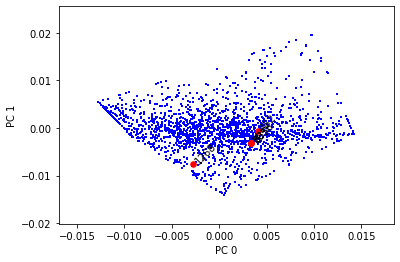

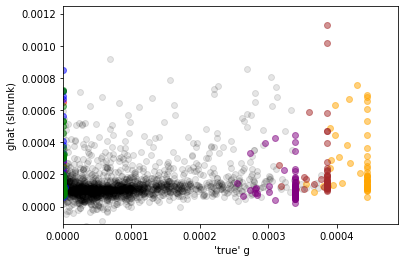

max words ['"minimal"' '"densities"' '"serial"' '"describes"' '"conducted"']
max words [1175  490 1681  506  364]


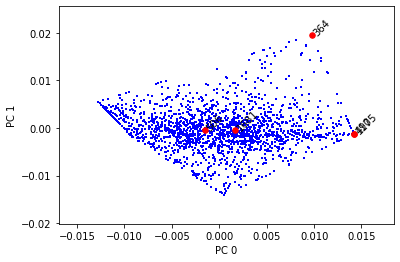

step 5


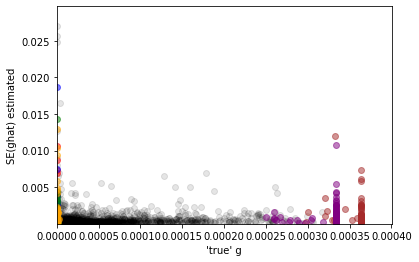

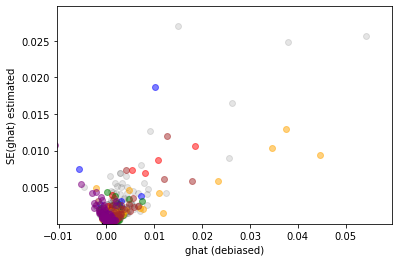

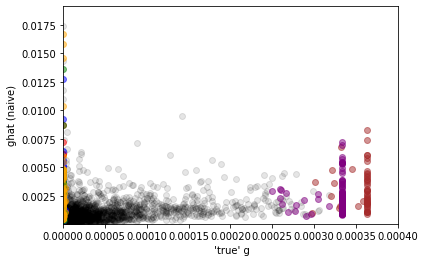

max words ['"critical"' '"x"' '"latent"' '"hybrid"' '"general"']
max words [ 452    0 1056  885  812]


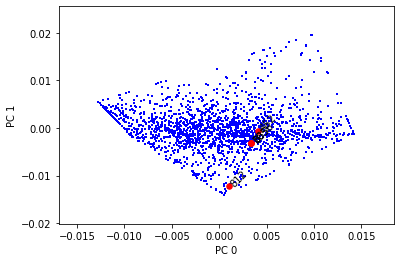

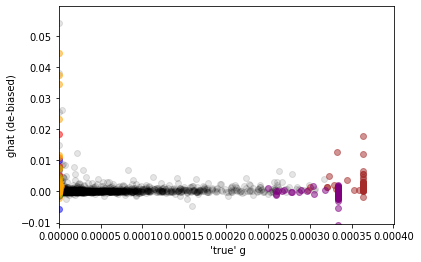

max words ['"critical"' '"x"' '"normally"' '"latent"' '"hybrid"']
max words [ 452    0 1268 1056  885]


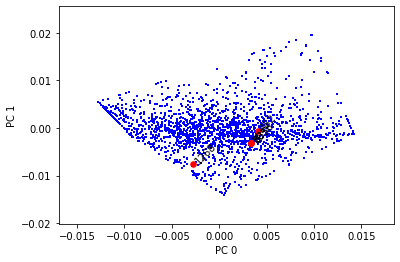

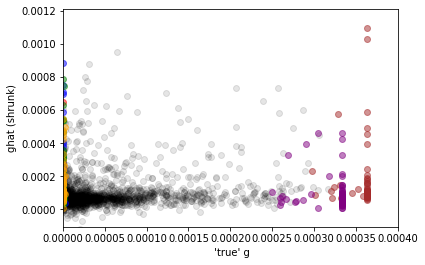

max words ['"minimal"' '"densities"' '"serial"' '"conducted"' '"describes"']
max words [1175  490 1681  364  506]


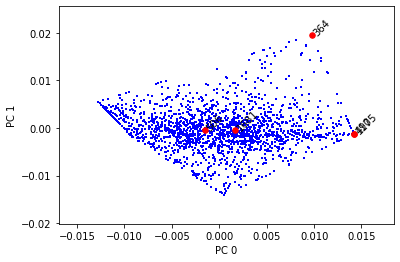

step 6


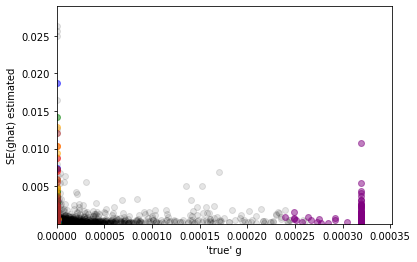

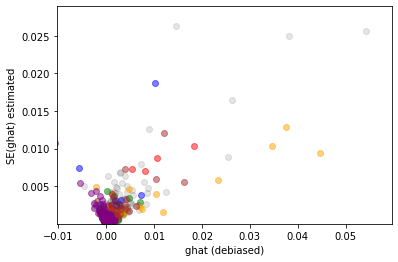

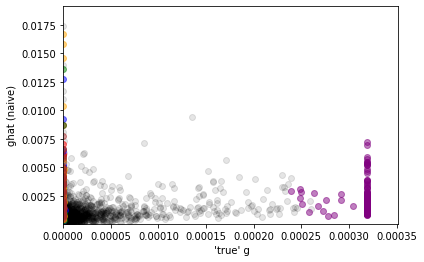

max words ['"critical"' '"x"' '"latent"' '"hybrid"' '"general"']
max words [ 452    0 1056  885  812]


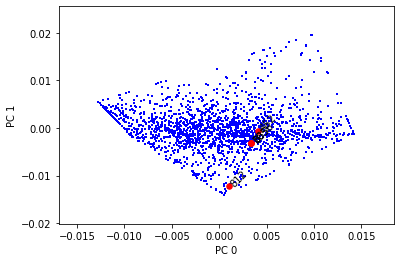

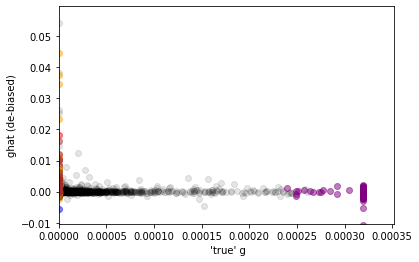

max words ['"critical"' '"x"' '"normally"' '"latent"' '"hybrid"']
max words [ 452    0 1268 1056  885]


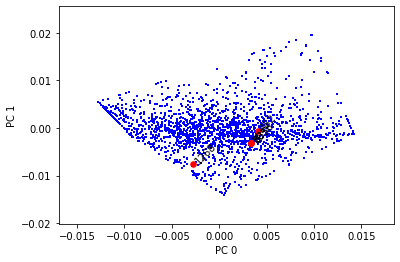

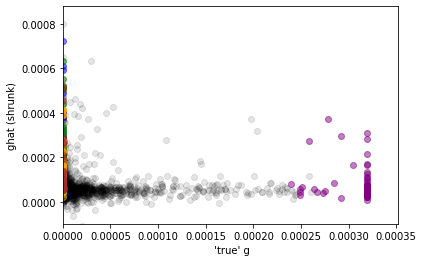

max words ['"serial"' '"conducted"' '"bands"' '"course"' '"principle"']
max words [1681  364  169  444 1444]


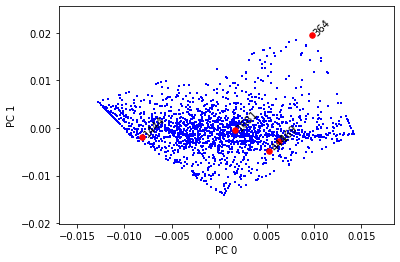

In [6]:
colors = ["red", "blue", "green", "orange", "brown", "purple"]
print([f"k={i} {colors[i]}" for i in range(6)])
for k_ in range(k):
    print(f'step {k_ + 1}')
    visualize_shrinkage(k_, gs0, gs1, gs2, gs3, vs, a_words, a_words_all, Cbar_pj, colors)

* Many $\hat{g}_j$'s are much larger than true $g_j$. Also a few words are just outliers. NMF learns to treat them as outliers; but anchor word algo does not. After projection of any meaning $u$'s (learned from NMF), these words are still very far away. 

* look at the "similarity" in SE plot and $\hat{g}$ plot. Have an appropriate shrinkage model is vital!!

* Or, real data simply doesn't fit our assumption: the 'true' g is just not what the data suggests

In [7]:
n_top = 20
for k_ in range(k):
    ix = (-vs[:, k_]).argsort()[:n_top]
    print(vocab[ix])
    print(np.sqrt(vs[ix, k_]))
    print((Y > 0).sum(axis = 0)[ix])

['"general"' '"critical"' '"normally"' '"uniform"' '"curves"' '"prices"'
 '"iterative"' '"community"' '"latent"' '"excellent"' '"interesting"'
 '"hybrid"' '"avoids"' '"chosen"' '"x"' '"twodimensional"' '"life"'
 '"single"' '"key"' '"processes"']
[0.02856111 0.02854249 0.02760613 0.02027635 0.01987857 0.01754437
 0.01484355 0.01432747 0.01428373 0.01326722 0.01232628 0.01187153
 0.0112295  0.01091527 0.01074864 0.01024187 0.010142   0.00991466
 0.00967315 0.0089052 ]
[27 11 24 15  9  5 15 23 14 20  5 13 20 20 18 18 14 17  7 20]
['"critical"' '"general"' '"normally"' '"curves"' '"uniform"' '"prices"'
 '"latent"' '"community"' '"excellent"' '"hybrid"' '"iterative"'
 '"interesting"' '"x"' '"twodimensional"' '"key"' '"avoids"' '"processes"'
 '"life"' '"chosen"' '"automatically"']
[0.02756524 0.0271673  0.02500955 0.01975252 0.01895254 0.0146496
 0.01390292 0.01336433 0.01297917 0.01144434 0.01125925 0.01116144
 0.01057624 0.00994041 0.00914741 0.00898013 0.00851399 0.00752448
 0.00723624 0.

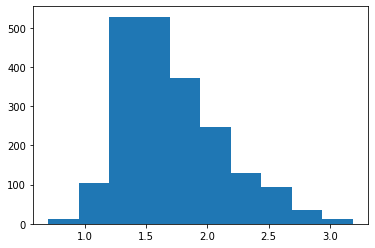

In [8]:
plt.hist(np.log10((Y > 0).sum(axis = 0)))
plt.show()

TODO: 

Artificially double or triple document lengths; then fit in two ways. 

In [9]:
# import rpy2
# import rpy2.interactive as r
# import rpy2.interactive.packages
# from rpy2.robjects import numpy2ri
# fastTopics = r.packages.importr("fastTopics")

# numpy2ri.activate()
# fit = fastTopics.fit_topic_model(X = Y, k = k)
# #numpy2ri.deactivate()